In [431]:
from datetime import datetime, timedelta
import json
import pandas as pd
import requests
import matplotlib.pyplot as plt

season = 2021
round = 19 # Mexico
drivers = ['max_verstappen', 'hamilton', 'bottas']

In [432]:
# fetch data

try:
    response = requests.get(
        url="https://ergast.com/api/f1/%d/%d/laps.json" % (season, round),
        params={
            "limit": "10000",
        },
    )
    print('Response HTTP Status Code: {status_code}'.format(
        status_code=response.status_code))

    lapTimesAll = json.loads(response.content)
except requests.exceptions.RequestException:
    print('HTTP Request failed')

Response HTTP Status Code: 200


In [433]:
# create table from raw data

lapTimesData = lapTimesAll['MRData']['RaceTable']['Races'][0]['Laps']

lapTimes = {
    'lap': [],
    'driver': [],
    'time': [],
    'position': []
}

for i in range(len(lapTimesData)):
    lap = lapTimesData[i]

    timings = lap['Timings']

    for j in range(len(timings)):
        timing = timings[j]

        lapTime = datetime.strptime(timing['time'], '%M:%S.%f')
        delta = timedelta(minutes=lapTime.minute, seconds=lapTime.second, microseconds=lapTime.microsecond)

        lapTimes['lap'].append(int(lap['number']))
        lapTimes['driver'].append(timing['driverId'])
        lapTimes['time'].append(delta)
        lapTimes['position'].append(int(timing['position']))

lapTimesDF = pd.DataFrame(lapTimes)
lapTimesDF.head()

,lap,driver,time,position
0,1,max_verstappen,0 days 00:01:18.399000,1
1,1,perez,0 days 00:01:19.651000,2
2,1,bottas,0 days 00:01:20.541000,3
3,1,leclerc,0 days 00:01:21.519000,4
4,1,sainz,0 days 00:01:22.506000,5


In [434]:
lapTimesDFDrivers = {}

for driver in drivers:
    lapTimesDFDriver = lapTimesDF[lapTimesDF.driver.eq(driver)].sort_values('lap').reset_index(drop=True)
    lapTimesDFDrivers[driver] = lapTimesDFDriver

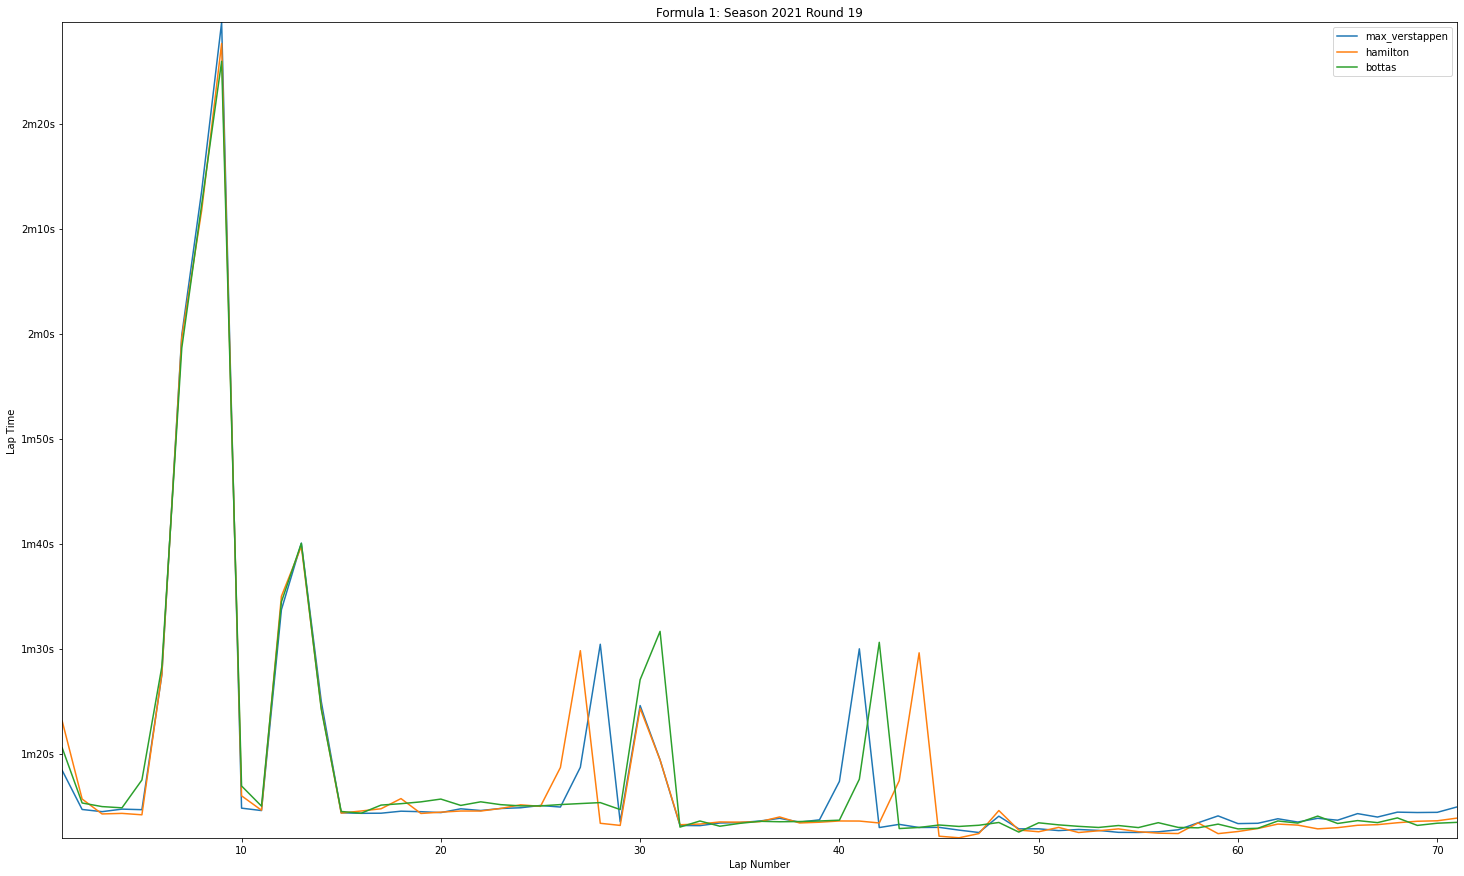

In [435]:
# plot

fig, ax = plt.subplots()
fig.set_size_inches(25, 15, forward=True)

ax.margins(x=0, y=0)
ax.set_title('Formula 1: Season %d Round %d' % (season, round))
ax.set_ylabel('Lap Time')
ax.set_xlabel('Lap Number')

def duration_fmt(x, pos):
    seconds = x / 10**9
    minutes = (seconds // 60)
    secondsLeft = seconds - (minutes*60)

    return '%dm%ds' % (minutes, secondsLeft)

ax.yaxis.set_major_formatter(duration_fmt)

for driver in lapTimesDFDrivers:
    ax.plot(lapTimesDFDrivers[driver].lap, lapTimesDFDrivers[driver].time, label=driver)

ax.legend()
plt.show()

In [436]:
# stack timing

stackedLapTimesDFDrivers = {}

for driver in lapTimesDFDrivers:
    stackedLapTimesDFDrivers[driver] = lapTimesDFDrivers[driver].assign(time=lapTimesDFDrivers[driver].time.cumsum())

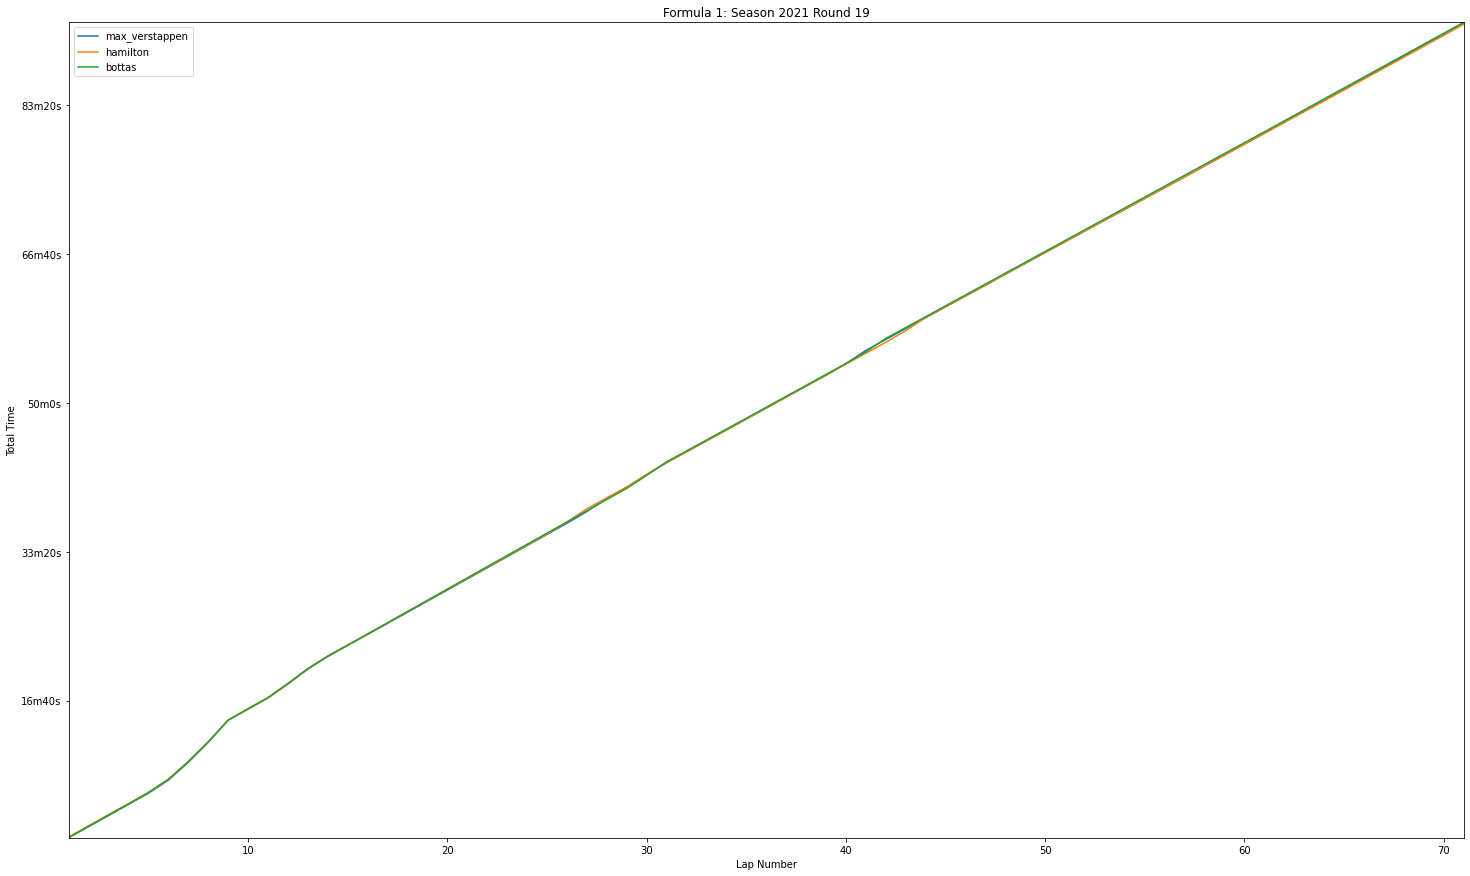

In [437]:
# plot

fig, ax = plt.subplots()
fig.set_size_inches(25, 15, forward=True)

ax.margins(x=0, y=0)
ax.set_title('Formula 1: Season %d Round %d' % (season, round))
ax.set_ylabel('Total Time')
ax.set_xlabel('Lap Number')

def duration_fmt(x, pos):
    seconds = x / 10**9
    minutes = (seconds // 60)
    secondsLeft = seconds - (minutes*60)

    return '%dm%ds' % (minutes, secondsLeft)

ax.yaxis.set_major_formatter(duration_fmt)

for driver in stackedLapTimesDFDrivers:
    df = stackedLapTimesDFDrivers[driver]

    ax.plot(df.lap, df.time, label=driver)

ax.legend()
plt.show()

In [438]:
# versus timing

versusData = []

versusA = stackedLapTimesDFDrivers['max_verstappen']
versusB = stackedLapTimesDFDrivers['hamilton']

for index, rowA in versusA.iterrows():
    rowB = versusB.loc[versusB['lap'] == rowA.lap].iloc[0]

    versusData.append([rowA.lap, '%s <> %s' % (rowA.driver, rowB.driver), rowA.time - rowB.time])

versusDF = pd.DataFrame(versusData, columns=['lap', 'driver', 'time'])
versusDF = versusDF.assign(time=lambda x: x['time'].dt.total_seconds())

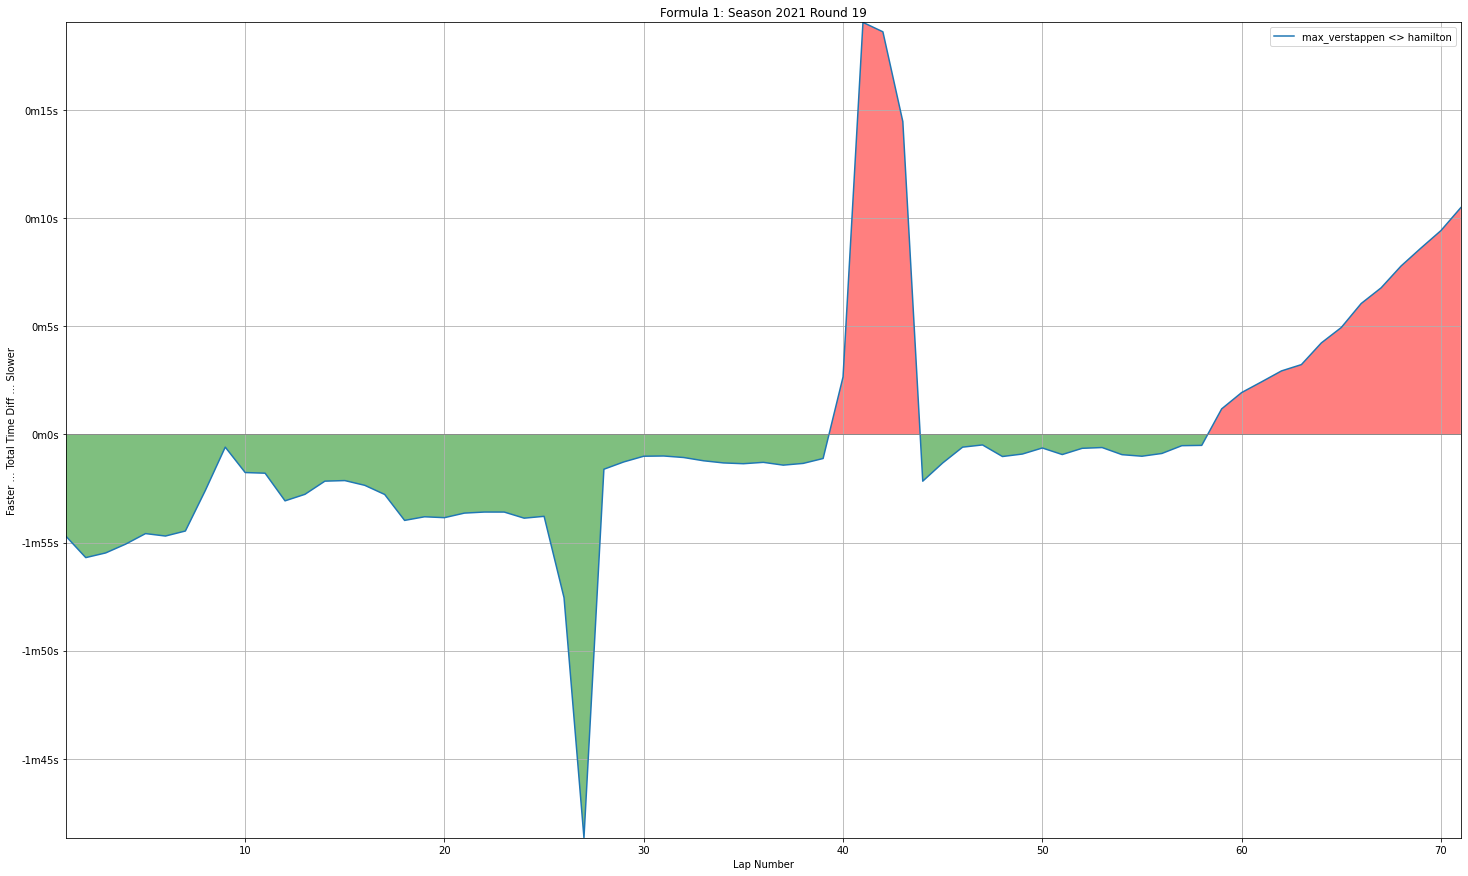

In [439]:
# plot

fig, ax = plt.subplots()
fig.set_size_inches(25, 15, forward=True)

ax.margins(x=0, y=0)
ax.set_title('Formula 1: Season %d Round %d' % (season, round))
ax.set_ylabel('Faster … Total Time Diff … Slower')
ax.set_xlabel('Lap Number')

def duration_s_fmt(seconds, pos):
    minutes = (seconds // 60)
    secondsLeft = seconds - (minutes*60)

    return '%dm%ds' % (minutes, secondsLeft)

ax.yaxis.set_major_formatter(duration_s_fmt)

ax.plot(versusDF.lap, versusDF.time, label=versusDF.iloc[0].driver)
ax.axhline(0, color='grey', linewidth=0.8)

ax.fill_between(versusDF.lap, 0, versusDF.time, where=versusDF.time > 0, facecolor='red', alpha=0.5, interpolate=True)
ax.fill_between(versusDF.lap, 0, versusDF.time, where=versusDF.time < 0, facecolor='green', alpha=0.5, interpolate=True)
ax.grid(True)

ax.legend()
plt.show()